In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math

#date, total_cases, new_cases_smoothed, total_deaths, new_deaths_smoothed, reproduction_rate, - Stefan
#new_tests_smoothed, positive_rate, total_vaccinations, people_vaccinated, new_vaccinations, new_vaccinations_smoothed, - Ion
#stringency_index, population, aged_70_older, gdp_per_capita, extreme_poverty, cardiovascular_death_rate, - Mirela
#diabetes_prevelance, female_smokers, male_smokers, handwashind_facilities, hospital_beds_per_thousand, life_expectancy, human_development_index - Dana


In [22]:
# Jupyter configuration
pd.set_option('display.max_rows', 500)

In [23]:
all_data = pd.read_csv('owid-covid-data.csv')

Separate the data into two datasets

In [24]:
moldova_dataset = all_data[all_data['location'] == 'Moldova']
moldova_dataset.to_csv('moldova-covid-data.csv')

dataset = moldova_dataset

In [25]:
# The shape of the dataset
dataset.shape

(604, 65)

Looking at these variables one can observe that for some variables there are pair variables that end wirh 'per_thousand' or 'per_million'. These variables generalize the information regarding the variable that is represented by tehm. We can exclude these variables because they have the same behaviour as the real measurements. For example, icu_patients in a way represents the same information as variable icu_patients_per_million and should have the same behaviour. The variables to be excluded are: 

* icu_patients_per_million
* hosp_patients_per_million
* weekly_icu_admissions_per_million
* weekly_hosp_admissions_per_million
* total_tests_per_thousand
* new_tests_per_thousand
* new_tests_smoothed
* new_tests_smoothed_per_thousand.
* etc

The variables used further will be the ones selected to work with.

Select only a subset of variables to work with

In [26]:
dataset = dataset[[
    'location',
    'date',
    'new_tests_smoothed', 
    'positive_rate', 
    'total_vaccinations', 
    'people_vaccinated', 
    'new_vaccinations', 
    'new_vaccinations_smoothed'
]]

dataset.shape

(604, 8)

In [27]:
# All available variables
dataset.columns.tolist()

['location',
 'date',
 'new_tests_smoothed',
 'positive_rate',
 'total_vaccinations',
 'people_vaccinated',
 'new_vaccinations',
 'new_vaccinations_smoothed']

### Changing the date types for the needed ones

In [28]:
# Fixing date column datatype
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['location'] = dataset['location'].astype('category');

/tmp/ipykernel_1125/1425383443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['date'] = pd.to_datetime(dataset['date'])
/tmp/ipykernel_1125/1425383443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['location'] = dataset['location'].astype('category');


In [29]:
# Variable types
dataset.dtypes

location                           category
date                         datetime64[ns]
new_tests_smoothed                  float64
positive_rate                       float64
total_vaccinations                  float64
people_vaccinated                   float64
new_vaccinations                    float64
new_vaccinations_smoothed           float64
dtype: object

#### There are two variables that are not numerical: date and tests_units. Initially, the values in datetime are character strings and do not provide any datetime operations (e.g. extract the year, day of the week,…). By applying the `to_datetime` function, pandas interprets the strings and convert these to datetime (i.e. `datetime64[ns, UTC]`) objects. In pandas we call these datetime objects similar to datetime.datetime from the standard library as `pandas.Timestamp`

In [30]:
start_date = dataset["date"].min()
end_date =  dataset["date"].max()

delta_time = end_date - start_date
delta_time

Timedelta('603 days 00:00:00')

#### This is the start and end date of our covid date selection. The date is collected for 603 days.

### Before dealing with missing values, let's take a look at the head and tail of the resulting dataset. 

In [31]:
dataset.head(10)

,location,date,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
75112,Moldova,2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN
75113,Moldova,2020-03-09,NaN,NaN,NaN,NaN,NaN,NaN
75114,Moldova,2020-03-10,NaN,NaN,NaN,NaN,NaN,NaN
75115,Moldova,2020-03-11,NaN,NaN,NaN,NaN,NaN,NaN
75116,Moldova,2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN
75117,Moldova,2020-03-13,NaN,NaN,NaN,NaN,NaN,NaN
75118,Moldova,2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN
75119,Moldova,2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN
75120,Moldova,2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN
75121,Moldova,2020-03-17,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
dataset.tail(10)

,location,date,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
75706,Moldova,2021-10-23,9845.0,0.169,1485935.0,NaN,2292.0,4220.0
75707,Moldova,2021-10-24,8890.0,0.184,1486884.0,NaN,949.0,4201.0
75708,Moldova,2021-10-25,7936.0,0.205,NaN,NaN,NaN,4245.0
75709,Moldova,2021-10-26,NaN,NaN,1497461.0,NaN,NaN,3517.0
75710,Moldova,2021-10-27,NaN,NaN,1502791.0,NaN,5330.0,3764.0
75711,Moldova,2021-10-28,NaN,NaN,1508749.0,NaN,5958.0,4101.0
75712,Moldova,2021-10-29,NaN,NaN,NaN,NaN,NaN,4266.0
75713,Moldova,2021-10-30,NaN,NaN,1518261.0,NaN,NaN,4618.0
75714,Moldova,2021-10-31,NaN,NaN,1520548.0,NaN,2287.0,4809.0
75715,Moldova,2021-11-01,NaN,NaN,1525820.0,NaN,5272.0,4807.0


All of the numerical variables are represented by `pandas` library as floats64. This is fine because there are a lot of missing values and soon we will replace them with mean or median, depending on the skewness, and these will not be integer numbers. 

Let's for now take a look at all unique values from the `tests_units` column.

This variable since its not numerical, it might have a weak relation to the other numerical variables and will not help much further when the prediction will be made.

In [33]:
stats_df = dataset.describe();
stats_df.loc['skewness'] = dataset.skew();
stats_df.loc['kurtosis'] = dataset.kurt();
stats_df

/tmp/ipykernel_1125/876448626.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_df.loc['skewness'] = dataset.skew();
/tmp/ipykernel_1125/876448626.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  stats_df.loc['kurtosis'] = dataset.kurt();


,new_tests_smoothed,positive_rate,total_vaccinations,people_vaccinated,new_vaccinations,new_vaccinations_smoothed
count,155.000000,155.000000,1.490000e+02,116.000000,112.000000,241.000000
mean,5682.251613,0.068194,6.475711e+05,285127.801724,8317.625000,6266.286307
std,1616.964820,0.067061,5.172161e+05,190810.881828,6919.944265,3651.044602
min,3681.000000,0.009000,3.849000e+03,3849.000000,900.000000,520.000000
25%,4588.500000,0.015000,1.503840e+05,96111.750000,3290.500000,3651.000000
50%,5211.000000,0.030000,5.777630e+05,331071.500000,6603.000000,5960.000000
75%,6097.500000,0.118500,1.034428e+06,458587.000000,10939.500000,8419.000000
max,12096.000000,0.271000,1.525820e+06,824986.000000,45233.000000,16176.000000
skewness,1.704139,1.092007,3.945227e-01,0.039349,2.089812,0.672894
kurtosis,3.366510,0.220778,-1.217733e+00,-1.100604,7.090763,-0.118985


#### There are two variables that are not numerical: date and tests_units. Initially, the values in datetime are character strings and do not provide any datetime operations (e.g. extract the year, day of the week,…). By applying the `to_datetime` function, pandas interprets the strings and convert these to datetime (i.e. `datetime64[ns, UTC]`) objects. In pandas we call these datetime objects similar to datetime.datetime from the standard library as `pandas.Timestamp`

### Data distribution in time

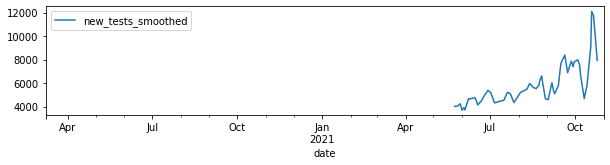

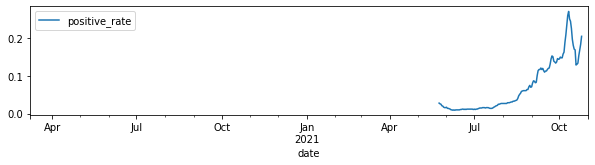

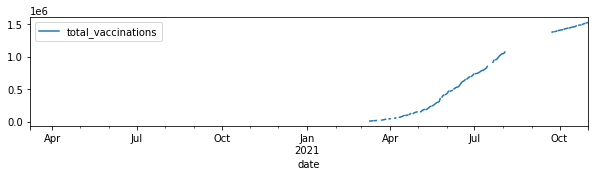

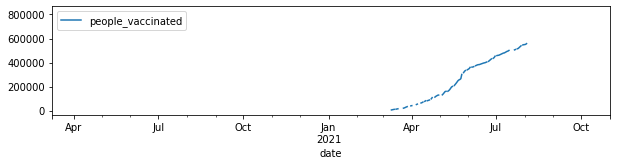

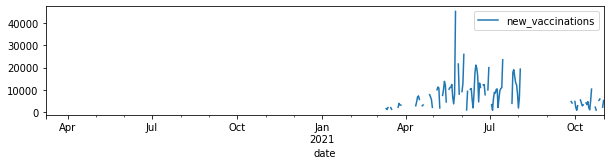

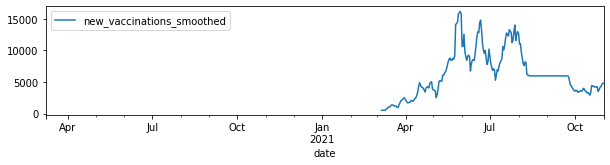

In [34]:
def plot_data_in_time():
    for column in dataset.columns:
        if column in ['date', 'location']:
            continue
        dataset.plot(kind='line', x='date', y=column, figsize=(10, 2));

plot_data_in_time()

As we can see from the plots above, the data related to tests and vaccination is available only starting with March 2021. This is because in Moldova tests and vaccinations started at that time. For the missing valeus up to March 2021, the row will not be removed because this will make out dataset a half smaller. NaN values will be left as they are up to March 2021. After March 2021, the missing values will be replaced with median or mean, depending on the analysis.

There is a clear similar behaviour between new_tests_smoothed, positive_rate, total_vaccinations and people_vaccinated. All of them are increasing. The new_vaccinations_variable and new_vaccinations_smoothed represent the same thing and just one of them will be used that is new_vaccinations_smoothed. At this moment the assumations are the following: people_vaccinated is highly correlated to total_vaccinations, new_tests_smoothed might not make the positive rate increate, new_vaccinations_smoothed might lead the positive rate to decrease. Also, positive_rate if it is bigger, then this might lead new_vaccinations_smoothed to increase because when people see that there are more Covid-19 cases, they are scared and want to vaccinate. 

As we can see, there is a period of time when the data about people_vaccinated and total_vaccinations are missing. This is cause by same missing portion of new_vaccinations. This might be cause by the absence of the data at the data provider in case. But this is not the last chunck of data that we have. We can replace this data with some approximations just for new_vaccination because this one is not increasing not decreasing. Then total_vaccination and people_vaccinated, at that portion the missing values will be replaced with the value from previous day plus new_vaccinations on teh current day. The new_vaccinations_smoothed variable can be used as a replacement for new_vaccinations variable since it has all the data available - the missing portion was smoothed based on the data next to that region.

For the missing data in the period August-October 2021, missing new_vaccinations will be replaced with median or mean, depending on the analysis. 

Now, let's see the distribution of the replaced missing data in time. 

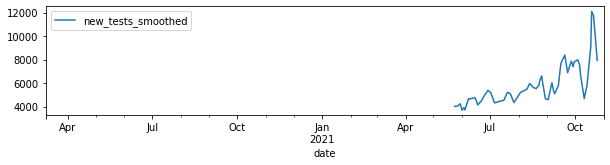

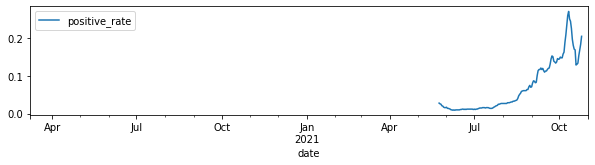

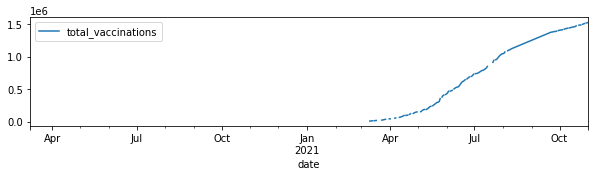

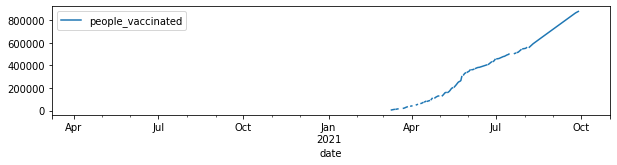

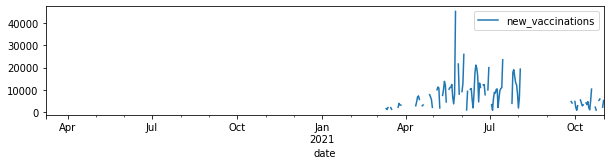

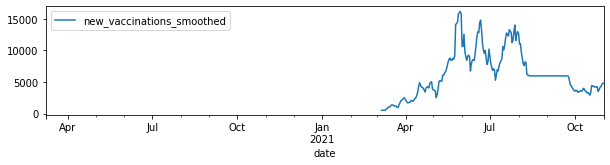

In [37]:
def missing_portion(date_str):
    return pd.to_datetime('2021-08-06') < pd.to_datetime(date_str) < pd.to_datetime('2021-09-29')

for index, row in dataset.iterrows():
    current_new_vacc_smoothed = dataset.at[index, 'new_vaccinations_smoothed']
    if not pd.isna(current_new_vacc_smoothed) and missing_portion(row['date']):
        for column in ['total_vaccinations', 'people_vaccinated']:
            if pd.isna(row[column]):
                dataset.at[index, column] = dataset.at[index - 1, column] + current_new_vacc_smoothed

plot_data_in_time()

In [35]:
def get_bins(n):
    return int(1 + 3.3 * math.log(n))

### Histograms

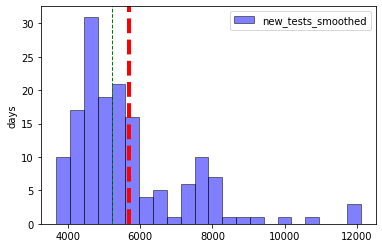

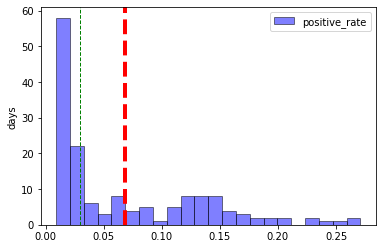

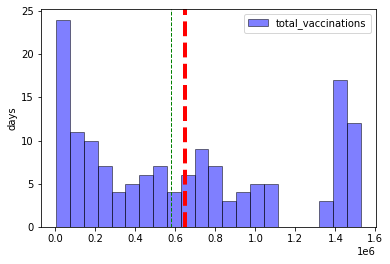

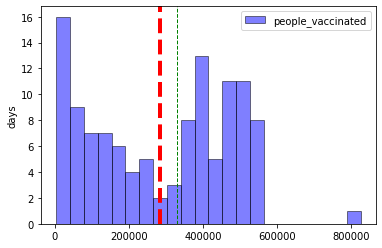

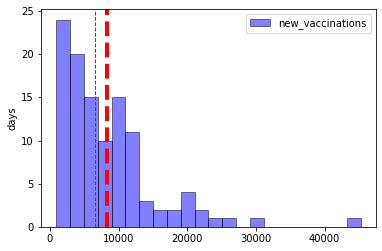

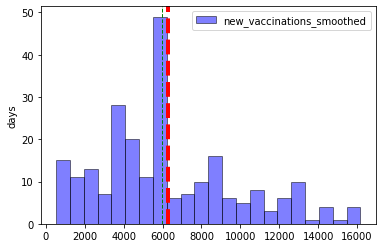

In [36]:
dataset_size = dataset.shape[0]
bins = get_bins(dataset_size)

for column in dataset.columns:
    if column in ['date', 'location']:
        continue
    plt.hist(dataset[column], bins=bins, alpha=0.5, label=column, color='blue', edgecolor='black')
    plt.axvline(dataset[column].mean(), color ='red', linewidth = 4, linestyle = 'dashed')
    plt.axvline(dataset[column].median(), color ='green', linewidth = 1, linestyle = 'dashed')
    plt.legend(loc='upper right')
    plt.ylabel('days')
    plt.show()

* new_tests_smoothed - skewed to the right with outliers on the right side. This distribution is skewed because, on the y axis there is the number of days, and when we read the plot, the conclusion is that there are fewer days when the number of tests if big. 

* positive_rate - skewed to the right. There about as many days when the positive_rate is bellow 0.05% as the number of days when positive rate is between 0.05% and 0.3%.

* total_vaccinations - 

### Box plots

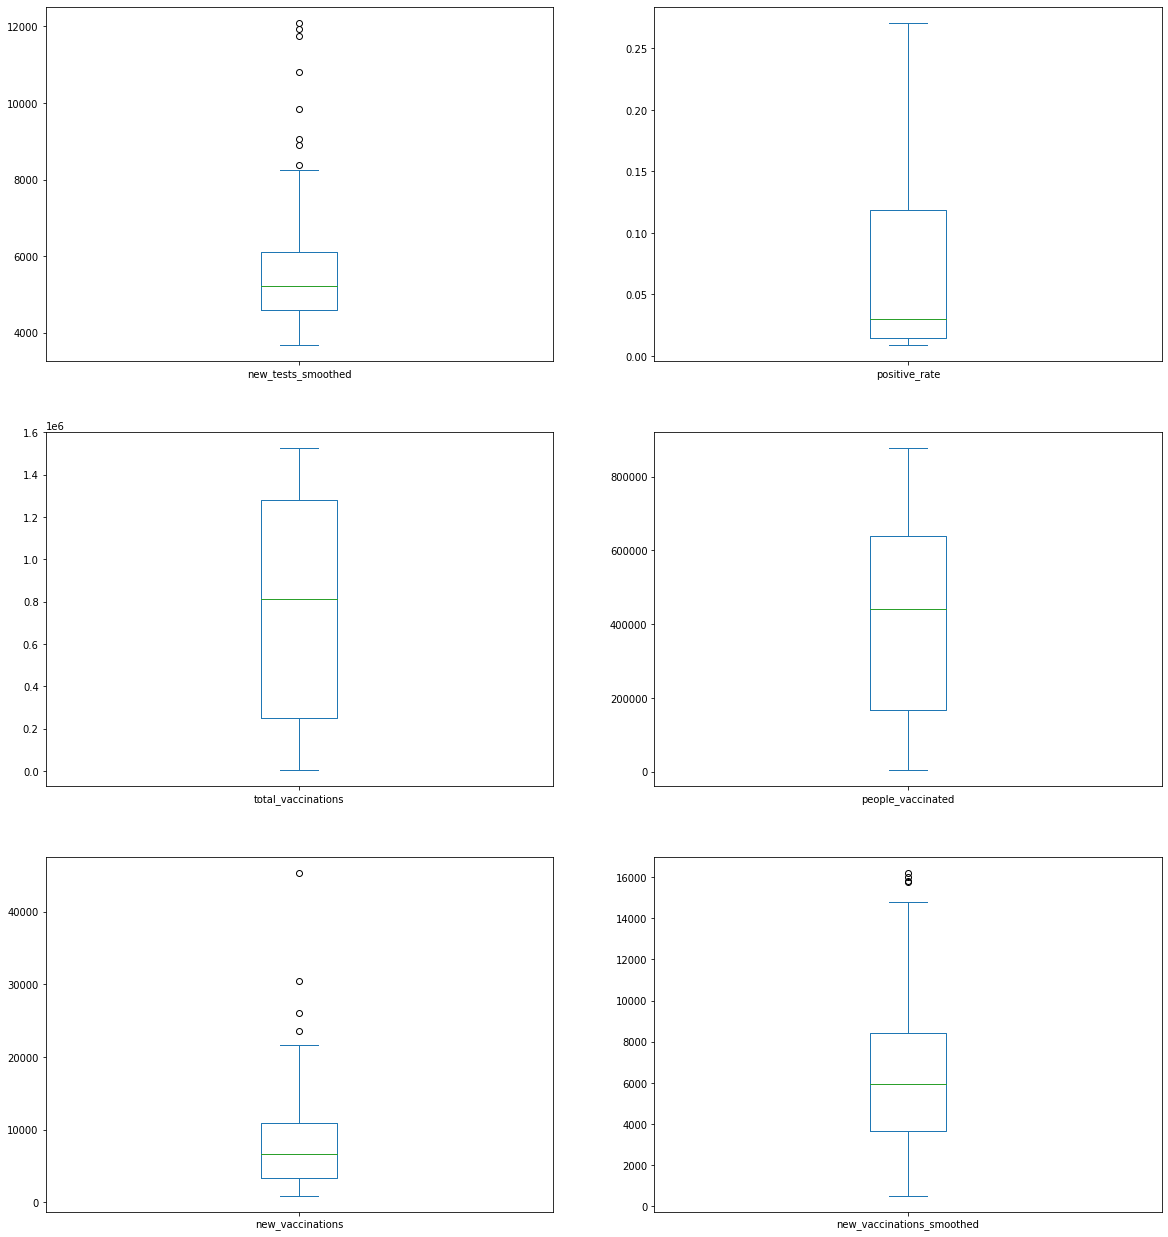

In [38]:
dataset.plot(kind='box', subplots=True, layout=(4, 2), sharex=False, sharey=False, figsize=(20, 30));
